<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[22:10:29] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


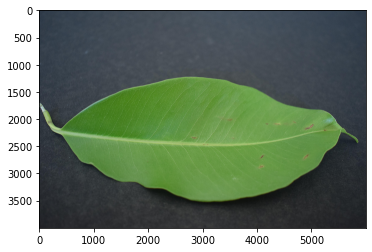

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

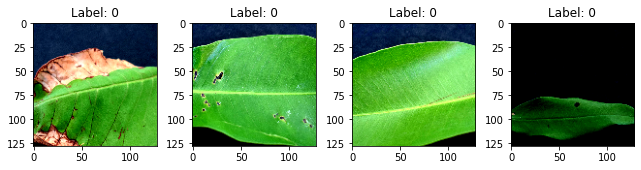

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[22:10:37] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[22:10:39] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.249272018200997 samples/sec                   batch loss = 1.1201539039611816 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2604700800921993 samples/sec                   batch loss = 0.9538562297821045 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.263360275184142 samples/sec                   batch loss = 0.7778546214103699 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2585681793920798 samples/sec                   batch loss = 0.2979774475097656 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.2659669793399595 samples/sec                   batch loss = 0.7673873901367188 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.2635262102059701 samples/sec                   batch loss = 0.8194877505302429 | accuracy = 0.5333333333333333


Epoch[1] Batch[35] Speed: 1.260468091417282 samples/sec                   batch loss = 0.5503248572349548 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.263620234022437 samples/sec                   batch loss = 0.5183183550834656 | accuracy = 0.55


Epoch[1] Batch[45] Speed: 1.2641116123021032 samples/sec                   batch loss = 0.6608261466026306 | accuracy = 0.5444444444444444


Epoch[1] Batch[50] Speed: 1.2612553392355044 samples/sec                   batch loss = 0.2858528792858124 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2728975401611569 samples/sec                   batch loss = 0.6194735765457153 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.2737528076750648 samples/sec                   batch loss = 0.6541516184806824 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.2675719498559617 samples/sec                   batch loss = 0.6419381499290466 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.2705879822569826 samples/sec                   batch loss = 0.3796970844268799 | accuracy = 0.6107142857142858


Epoch[1] Batch[75] Speed: 1.272906618323595 samples/sec                   batch loss = 0.23289000988006592 | accuracy = 0.62


Epoch[1] Batch[80] Speed: 1.2709138849323005 samples/sec                   batch loss = 1.6878559589385986 | accuracy = 0.609375


Epoch[1] Batch[85] Speed: 1.262527833086292 samples/sec                   batch loss = 0.33931857347488403 | accuracy = 0.6088235294117647


Epoch[1] Batch[90] Speed: 1.2649872518944971 samples/sec                   batch loss = 0.32865968346595764 | accuracy = 0.6138888888888889


Epoch[1] Batch[95] Speed: 1.263601580411799 samples/sec                   batch loss = 0.540957510471344 | accuracy = 0.6236842105263158


Epoch[1] Batch[100] Speed: 1.2642053422217145 samples/sec                   batch loss = 0.4734916090965271 | accuracy = 0.6225


Epoch[1] Batch[105] Speed: 1.2666102008031097 samples/sec                   batch loss = 0.7496364712715149 | accuracy = 0.6261904761904762


Epoch[1] Batch[110] Speed: 1.2627827921132677 samples/sec                   batch loss = 0.7670232653617859 | accuracy = 0.6181818181818182


Epoch[1] Batch[115] Speed: 1.267637171959565 samples/sec                   batch loss = 0.6682090759277344 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.2667616870417844 samples/sec                   batch loss = 0.43684250116348267 | accuracy = 0.63125


Epoch[1] Batch[125] Speed: 1.2633986152419772 samples/sec                   batch loss = 0.5321510434150696 | accuracy = 0.638


Epoch[1] Batch[130] Speed: 1.2624818506931446 samples/sec                   batch loss = 0.416882187128067 | accuracy = 0.6384615384615384


Epoch[1] Batch[135] Speed: 1.2669962561524273 samples/sec                   batch loss = 1.1460813283920288 | accuracy = 0.6314814814814815


Epoch[1] Batch[140] Speed: 1.2617549381122322 samples/sec                   batch loss = 0.2474416047334671 | accuracy = 0.6375


Epoch[1] Batch[145] Speed: 1.2657207593562885 samples/sec                   batch loss = 0.8665238618850708 | accuracy = 0.6396551724137931


Epoch[1] Batch[150] Speed: 1.2617225807305548 samples/sec                   batch loss = 0.6528123617172241 | accuracy = 0.6416666666666667


Epoch[1] Batch[155] Speed: 1.2691391350281749 samples/sec                   batch loss = 0.48913612961769104 | accuracy = 0.6435483870967742


Epoch[1] Batch[160] Speed: 1.2619761704176196 samples/sec                   batch loss = 0.7379319667816162 | accuracy = 0.6375


Epoch[1] Batch[165] Speed: 1.2631140219586425 samples/sec                   batch loss = 1.2314687967300415 | accuracy = 0.6333333333333333


Epoch[1] Batch[170] Speed: 1.262274021663705 samples/sec                   batch loss = 0.4755966067314148 | accuracy = 0.6338235294117647


Epoch[1] Batch[175] Speed: 1.2636672511783693 samples/sec                   batch loss = 0.7176796197891235 | accuracy = 0.6342857142857142


Epoch[1] Batch[180] Speed: 1.2621798182475434 samples/sec                   batch loss = 0.4938986003398895 | accuracy = 0.6333333333333333


Epoch[1] Batch[185] Speed: 1.2613440941783445 samples/sec                   batch loss = 0.7242702841758728 | accuracy = 0.6310810810810811


Epoch[1] Batch[190] Speed: 1.2647375991613654 samples/sec                   batch loss = 0.671613872051239 | accuracy = 0.6289473684210526


Epoch[1] Batch[195] Speed: 1.2607352929573095 samples/sec                   batch loss = 0.5158814191818237 | accuracy = 0.6307692307692307


Epoch[1] Batch[200] Speed: 1.259279986645514 samples/sec                   batch loss = 0.4385443925857544 | accuracy = 0.63625


Epoch[1] Batch[205] Speed: 1.2618142484724475 samples/sec                   batch loss = 1.4089643955230713 | accuracy = 0.6365853658536585


Epoch[1] Batch[210] Speed: 1.2641665721649582 samples/sec                   batch loss = 0.5901751518249512 | accuracy = 0.6357142857142857


Epoch[1] Batch[215] Speed: 1.2680016198045443 samples/sec                   batch loss = 0.49800121784210205 | accuracy = 0.6395348837209303


Epoch[1] Batch[220] Speed: 1.2686422103747237 samples/sec                   batch loss = 0.8138663172721863 | accuracy = 0.6409090909090909


Epoch[1] Batch[225] Speed: 1.274029928724498 samples/sec                   batch loss = 0.43947169184684753 | accuracy = 0.6444444444444445


Epoch[1] Batch[230] Speed: 1.2682159408994942 samples/sec                   batch loss = 0.701734185218811 | accuracy = 0.6445652173913043


Epoch[1] Batch[235] Speed: 1.2678876833896155 samples/sec                   batch loss = 0.5485151410102844 | accuracy = 0.6414893617021277


Epoch[1] Batch[240] Speed: 1.270347560558234 samples/sec                   batch loss = 0.5524928569793701 | accuracy = 0.64375


Epoch[1] Batch[245] Speed: 1.2688339092309522 samples/sec                   batch loss = 0.5705124735832214 | accuracy = 0.6459183673469387


Epoch[1] Batch[250] Speed: 1.2648325662034485 samples/sec                   batch loss = 0.4617839753627777 | accuracy = 0.649


Epoch[1] Batch[255] Speed: 1.2642811745629028 samples/sec                   batch loss = 0.7326778173446655 | accuracy = 0.65


Epoch[1] Batch[260] Speed: 1.2652081880547092 samples/sec                   batch loss = 0.9759238362312317 | accuracy = 0.6509615384615385


Epoch[1] Batch[265] Speed: 1.269839213041339 samples/sec                   batch loss = 0.688094437122345 | accuracy = 0.6537735849056604


Epoch[1] Batch[270] Speed: 1.2724031690674937 samples/sec                   batch loss = 0.4052973985671997 | accuracy = 0.6555555555555556


Epoch[1] Batch[275] Speed: 1.264877194196673 samples/sec                   batch loss = 0.5252113938331604 | accuracy = 0.6545454545454545


Epoch[1] Batch[280] Speed: 1.2630797880926168 samples/sec                   batch loss = 1.6684411764144897 | accuracy = 0.6571428571428571


Epoch[1] Batch[285] Speed: 1.264740650089583 samples/sec                   batch loss = 0.428581565618515 | accuracy = 0.6596491228070176


Epoch[1] Batch[290] Speed: 1.2675191832860364 samples/sec                   batch loss = 0.8465955257415771 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.2692056707049437 samples/sec                   batch loss = 0.3414106070995331 | accuracy = 0.6593220338983051


Epoch[1] Batch[300] Speed: 1.267508170853701 samples/sec                   batch loss = 0.6805338263511658 | accuracy = 0.6616666666666666


Epoch[1] Batch[305] Speed: 1.2651100164778137 samples/sec                   batch loss = 0.5628169775009155 | accuracy = 0.6631147540983606


Epoch[1] Batch[310] Speed: 1.269725714925764 samples/sec                   batch loss = 0.6903445720672607 | accuracy = 0.6653225806451613


Epoch[1] Batch[315] Speed: 1.2661067503592929 samples/sec                   batch loss = 0.8543962836265564 | accuracy = 0.6603174603174603


Epoch[1] Batch[320] Speed: 1.2711512464880323 samples/sec                   batch loss = 0.28895238041877747 | accuracy = 0.6640625


Epoch[1] Batch[325] Speed: 1.2606975880386084 samples/sec                   batch loss = 0.5708011984825134 | accuracy = 0.6661538461538462


Epoch[1] Batch[330] Speed: 1.266347003143145 samples/sec                   batch loss = 0.23009255528450012 | accuracy = 0.668939393939394


Epoch[1] Batch[335] Speed: 1.2634878624036732 samples/sec                   batch loss = 0.7429022192955017 | accuracy = 0.6686567164179105


Epoch[1] Batch[340] Speed: 1.2657910435779756 samples/sec                   batch loss = 0.45811498165130615 | accuracy = 0.6683823529411764


Epoch[1] Batch[345] Speed: 1.2603782287996135 samples/sec                   batch loss = 0.5655087232589722 | accuracy = 0.6673913043478261


Epoch[1] Batch[350] Speed: 1.2641357102325108 samples/sec                   batch loss = 0.7305660247802734 | accuracy = 0.6685714285714286


Epoch[1] Batch[355] Speed: 1.2667830166127125 samples/sec                   batch loss = 0.7305430173873901 | accuracy = 0.6683098591549296


Epoch[1] Batch[360] Speed: 1.263224438820314 samples/sec                   batch loss = 0.7808250188827515 | accuracy = 0.6701388888888888


Epoch[1] Batch[365] Speed: 1.2663277910348287 samples/sec                   batch loss = 0.8110061883926392 | accuracy = 0.6684931506849315


Epoch[1] Batch[370] Speed: 1.262892200436937 samples/sec                   batch loss = 0.22116559743881226 | accuracy = 0.6682432432432432


Epoch[1] Batch[375] Speed: 1.258487933126146 samples/sec                   batch loss = 0.49673396348953247 | accuracy = 0.668


Epoch[1] Batch[380] Speed: 1.2653765176384517 samples/sec                   batch loss = 0.38254642486572266 | accuracy = 0.6690789473684211


Epoch[1] Batch[385] Speed: 1.267371153894965 samples/sec                   batch loss = 0.503795325756073 | accuracy = 0.6694805194805195


Epoch[1] Batch[390] Speed: 1.2610096214915303 samples/sec                   batch loss = 0.4656054973602295 | accuracy = 0.6685897435897435


Epoch[1] Batch[395] Speed: 1.261938581080898 samples/sec                   batch loss = 0.24522750079631805 | accuracy = 0.6721518987341772


Epoch[1] Batch[400] Speed: 1.2641319002218927 samples/sec                   batch loss = 0.8255242109298706 | accuracy = 0.67125


Epoch[1] Batch[405] Speed: 1.2644586921051448 samples/sec                   batch loss = 0.30105870962142944 | accuracy = 0.6722222222222223


Epoch[1] Batch[410] Speed: 1.2598817061629026 samples/sec                   batch loss = 0.6543471217155457 | accuracy = 0.6719512195121952


Epoch[1] Batch[415] Speed: 1.265490098612218 samples/sec                   batch loss = 0.9621846675872803 | accuracy = 0.6716867469879518


Epoch[1] Batch[420] Speed: 1.2653374848518948 samples/sec                   batch loss = 0.49087825417518616 | accuracy = 0.6714285714285714


Epoch[1] Batch[425] Speed: 1.2648366665073423 samples/sec                   batch loss = 0.7497318983078003 | accuracy = 0.6711764705882353


Epoch[1] Batch[430] Speed: 1.2632285287044414 samples/sec                   batch loss = 0.418301522731781 | accuracy = 0.6703488372093023


Epoch[1] Batch[435] Speed: 1.2643143302536117 samples/sec                   batch loss = 0.3604978919029236 | accuracy = 0.6701149425287356


Epoch[1] Batch[440] Speed: 1.2628619710464564 samples/sec                   batch loss = 1.0764753818511963 | accuracy = 0.66875


Epoch[1] Batch[445] Speed: 1.2636694403214803 samples/sec                   batch loss = 0.5847102403640747 | accuracy = 0.6696629213483146


Epoch[1] Batch[450] Speed: 1.259806779050367 samples/sec                   batch loss = 0.14152459800243378 | accuracy = 0.6727777777777778


Epoch[1] Batch[455] Speed: 1.2623618752209311 samples/sec                   batch loss = 0.6842901110649109 | accuracy = 0.6725274725274726


Epoch[1] Batch[460] Speed: 1.2639321925720588 samples/sec                   batch loss = 0.9379347562789917 | accuracy = 0.6733695652173913


Epoch[1] Batch[465] Speed: 1.2689422571769533 samples/sec                   batch loss = 0.7408629059791565 | accuracy = 0.6736559139784947


Epoch[1] Batch[470] Speed: 1.2705690261418654 samples/sec                   batch loss = 0.3804948925971985 | accuracy = 0.675531914893617


Epoch[1] Batch[475] Speed: 1.273007162801991 samples/sec                   batch loss = 0.2900902330875397 | accuracy = 0.6778947368421052


Epoch[1] Batch[480] Speed: 1.262623798869034 samples/sec                   batch loss = 0.517331063747406 | accuracy = 0.6786458333333333


Epoch[1] Batch[485] Speed: 1.2606889673815114 samples/sec                   batch loss = 0.6969992518424988 | accuracy = 0.6814432989690722


Epoch[1] Batch[490] Speed: 1.2618032400481882 samples/sec                   batch loss = 0.3841616213321686 | accuracy = 0.6816326530612244


Epoch[1] Batch[495] Speed: 1.2690511995847593 samples/sec                   batch loss = 1.1389846801757812 | accuracy = 0.6813131313131313


Epoch[1] Batch[500] Speed: 1.2602373530383633 samples/sec                   batch loss = 0.5410139560699463 | accuracy = 0.6805


Epoch[1] Batch[505] Speed: 1.2623564611887006 samples/sec                   batch loss = 0.3537904918193817 | accuracy = 0.6816831683168317


Epoch[1] Batch[510] Speed: 1.263006571885807 samples/sec                   batch loss = 1.074211597442627 | accuracy = 0.6808823529411765


Epoch[1] Batch[515] Speed: 1.2728780322076407 samples/sec                   batch loss = 0.18121176958084106 | accuracy = 0.6820388349514563


Epoch[1] Batch[520] Speed: 1.2615152861547076 samples/sec                   batch loss = 0.48422718048095703 | accuracy = 0.6831730769230769


Epoch[1] Batch[525] Speed: 1.268008615726838 samples/sec                   batch loss = 0.45614269375801086 | accuracy = 0.6823809523809524


Epoch[1] Batch[530] Speed: 1.264742556927194 samples/sec                   batch loss = 0.3269573450088501 | accuracy = 0.6825471698113208


Epoch[1] Batch[535] Speed: 1.2649351771478308 samples/sec                   batch loss = 0.3390214443206787 | accuracy = 0.6831775700934579


Epoch[1] Batch[540] Speed: 1.2689855439469746 samples/sec                   batch loss = 0.509911298751831 | accuracy = 0.6847222222222222


Epoch[1] Batch[545] Speed: 1.277865966176328 samples/sec                   batch loss = 1.0647835731506348 | accuracy = 0.6857798165137615


Epoch[1] Batch[550] Speed: 1.2732092656446317 samples/sec                   batch loss = 0.5025513768196106 | accuracy = 0.6863636363636364


Epoch[1] Batch[555] Speed: 1.2658390819861127 samples/sec                   batch loss = 0.5037949681282043 | accuracy = 0.6864864864864865


Epoch[1] Batch[560] Speed: 1.2644749884836806 samples/sec                   batch loss = 0.9113331437110901 | accuracy = 0.6879464285714286


Epoch[1] Batch[565] Speed: 1.2704290378310676 samples/sec                   batch loss = 0.3286254405975342 | accuracy = 0.6893805309734513


Epoch[1] Batch[570] Speed: 1.2704053727528248 samples/sec                   batch loss = 0.8702567219734192 | accuracy = 0.6885964912280702


Epoch[1] Batch[575] Speed: 1.2676247208193931 samples/sec                   batch loss = 0.4197293817996979 | accuracy = 0.6895652173913044


Epoch[1] Batch[580] Speed: 1.2643411037901635 samples/sec                   batch loss = 0.29552778601646423 | accuracy = 0.6905172413793104


Epoch[1] Batch[585] Speed: 1.2719356994252293 samples/sec                   batch loss = 0.39973515272140503 | accuracy = 0.6914529914529914


Epoch[1] Batch[590] Speed: 1.2653017943870708 samples/sec                   batch loss = 0.5564231276512146 | accuracy = 0.6911016949152542


Epoch[1] Batch[595] Speed: 1.263202563145574 samples/sec                   batch loss = 0.32821255922317505 | accuracy = 0.6907563025210084


Epoch[1] Batch[600] Speed: 1.2615093102504489 samples/sec                   batch loss = 0.8887728452682495 | accuracy = 0.69125


Epoch[1] Batch[605] Speed: 1.2636128105808002 samples/sec                   batch loss = 0.8117992877960205 | accuracy = 0.6904958677685951


Epoch[1] Batch[610] Speed: 1.2677999212745452 samples/sec                   batch loss = 0.2348453253507614 | accuracy = 0.690983606557377


Epoch[1] Batch[615] Speed: 1.2717134680052244 samples/sec                   batch loss = 0.898973822593689 | accuracy = 0.6906504065040651


Epoch[1] Batch[620] Speed: 1.2656138200805676 samples/sec                   batch loss = 0.44392138719558716 | accuracy = 0.6903225806451613


Epoch[1] Batch[625] Speed: 1.2672387610390998 samples/sec                   batch loss = 0.3038444519042969 | accuracy = 0.6908


Epoch[1] Batch[630] Speed: 1.2651488444250427 samples/sec                   batch loss = 0.42723822593688965 | accuracy = 0.6904761904761905


Epoch[1] Batch[635] Speed: 1.2647465613048923 samples/sec                   batch loss = 0.4508926272392273 | accuracy = 0.6897637795275591


Epoch[1] Batch[640] Speed: 1.266095475817714 samples/sec                   batch loss = 0.33293136954307556 | accuracy = 0.690625


Epoch[1] Batch[645] Speed: 1.2664083710953729 samples/sec                   batch loss = 0.532321572303772 | accuracy = 0.6906976744186046


Epoch[1] Batch[650] Speed: 1.2656217444247957 samples/sec                   batch loss = 0.7513418197631836 | accuracy = 0.6903846153846154


Epoch[1] Batch[655] Speed: 1.2687087898978897 samples/sec                   batch loss = 0.39527538418769836 | accuracy = 0.6900763358778625


Epoch[1] Batch[660] Speed: 1.2631805931217965 samples/sec                   batch loss = 0.29241707921028137 | accuracy = 0.690530303030303


Epoch[1] Batch[665] Speed: 1.2608407460726334 samples/sec                   batch loss = 0.5058864951133728 | accuracy = 0.6898496240601504


Epoch[1] Batch[670] Speed: 1.261510922790465 samples/sec                   batch loss = 0.34887227416038513 | accuracy = 0.6888059701492537


Epoch[1] Batch[675] Speed: 1.267890557900182 samples/sec                   batch loss = 0.39327460527420044 | accuracy = 0.6892592592592592


Epoch[1] Batch[680] Speed: 1.262091420371309 samples/sec                   batch loss = 0.8069523572921753 | accuracy = 0.6893382352941176


Epoch[1] Batch[685] Speed: 1.2656343472007414 samples/sec                   batch loss = 0.06284204870462418 | accuracy = 0.6897810218978102


Epoch[1] Batch[690] Speed: 1.267091658404281 samples/sec                   batch loss = 0.8894471526145935 | accuracy = 0.6894927536231884


Epoch[1] Batch[695] Speed: 1.2624718756161026 samples/sec                   batch loss = 0.5025865435600281 | accuracy = 0.6888489208633094


Epoch[1] Batch[700] Speed: 1.2671937748255035 samples/sec                   batch loss = 0.39800742268562317 | accuracy = 0.6896428571428571


Epoch[1] Batch[705] Speed: 1.2680900807789512 samples/sec                   batch loss = 0.4595292806625366 | accuracy = 0.6897163120567376


Epoch[1] Batch[710] Speed: 1.2648376200701974 samples/sec                   batch loss = 0.6356760859489441 | accuracy = 0.6897887323943662


Epoch[1] Batch[715] Speed: 1.2644219076720866 samples/sec                   batch loss = 0.6130571365356445 | accuracy = 0.6888111888111889


Epoch[1] Batch[720] Speed: 1.2662930960177003 samples/sec                   batch loss = 0.6343963146209717 | accuracy = 0.6881944444444444


Epoch[1] Batch[725] Speed: 1.26805634339343 samples/sec                   batch loss = 0.9228720664978027 | accuracy = 0.6886206896551724


Epoch[1] Batch[730] Speed: 1.2618917873842381 samples/sec                   batch loss = 0.23198281228542328 | accuracy = 0.689041095890411


Epoch[1] Batch[735] Speed: 1.2677621758046205 samples/sec                   batch loss = 0.6267157196998596 | accuracy = 0.6887755102040817


Epoch[1] Batch[740] Speed: 1.263690094784199 samples/sec                   batch loss = 0.43995165824890137 | accuracy = 0.6891891891891891


Epoch[1] Batch[745] Speed: 1.2628717621685617 samples/sec                   batch loss = 0.5776066184043884 | accuracy = 0.6889261744966443


Epoch[1] Batch[750] Speed: 1.2614729817650816 samples/sec                   batch loss = 0.31156206130981445 | accuracy = 0.6896666666666667


Epoch[1] Batch[755] Speed: 1.2651112566456697 samples/sec                   batch loss = 0.6312783360481262 | accuracy = 0.6903973509933775


Epoch[1] Batch[760] Speed: 1.264611856520073 samples/sec                   batch loss = 0.6397724747657776 | accuracy = 0.6891447368421053


Epoch[1] Batch[765] Speed: 1.2683346346378432 samples/sec                   batch loss = 0.5693275928497314 | accuracy = 0.688562091503268


Epoch[1] Batch[770] Speed: 1.2677899577849592 samples/sec                   batch loss = 0.3403513729572296 | accuracy = 0.6886363636363636


Epoch[1] Batch[775] Speed: 1.263815654178327 samples/sec                   batch loss = 0.37143638730049133 | accuracy = 0.6887096774193548


Epoch[1] Batch[780] Speed: 1.2652229771247736 samples/sec                   batch loss = 0.6298213005065918 | accuracy = 0.6891025641025641


Epoch[1] Batch[785] Speed: 1.2654118305469666 samples/sec                   batch loss = 0.479483038187027 | accuracy = 0.6898089171974522


[Epoch 1] training: accuracy=0.6900380710659898
[Epoch 1] time cost: 649.651123046875
[Epoch 1] validation: validation accuracy=0.7977777777777778


Epoch[2] Batch[5] Speed: 1.2649238280926036 samples/sec                   batch loss = 0.5869861245155334 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2663098220282842 samples/sec                   batch loss = 1.159813404083252 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2666850786766124 samples/sec                   batch loss = 0.8073803186416626 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2659927720794877 samples/sec                   batch loss = 0.6212477087974548 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.268859531033982 samples/sec                   batch loss = 0.5762829184532166 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.267085055378464 samples/sec                   batch loss = 0.6230459213256836 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.264234873835852 samples/sec                   batch loss = 0.6162447929382324 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.2653583847486192 samples/sec                   batch loss = 0.5372073650360107 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.2693815005595512 samples/sec                   batch loss = 0.7370585203170776 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.2630835917638705 samples/sec                   batch loss = 0.2137511521577835 | accuracy = 0.77


Epoch[2] Batch[55] Speed: 1.2735108002223776 samples/sec                   batch loss = 0.3429430425167084 | accuracy = 0.7727272727272727


Epoch[2] Batch[60] Speed: 1.2726296960754857 samples/sec                   batch loss = 0.1996343582868576 | accuracy = 0.775


Epoch[2] Batch[65] Speed: 1.2765086700962616 samples/sec                   batch loss = 1.6181459426879883 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.2654802668479364 samples/sec                   batch loss = 0.3064597249031067 | accuracy = 0.7535714285714286


Epoch[2] Batch[75] Speed: 1.2624266572437992 samples/sec                   batch loss = 0.43033015727996826 | accuracy = 0.7566666666666667


Epoch[2] Batch[80] Speed: 1.2603680028859554 samples/sec                   batch loss = 0.8174132108688354 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.262220270814498 samples/sec                   batch loss = 2.7366342544555664 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.2636217567904766 samples/sec                   batch loss = 1.024899959564209 | accuracy = 0.725


Epoch[2] Batch[95] Speed: 1.270404506973997 samples/sec                   batch loss = 0.6463680267333984 | accuracy = 0.7236842105263158


Epoch[2] Batch[100] Speed: 1.2641760025004396 samples/sec                   batch loss = 0.6538491249084473 | accuracy = 0.7225


Epoch[2] Batch[105] Speed: 1.2610447858683025 samples/sec                   batch loss = 1.0693053007125854 | accuracy = 0.7214285714285714


Epoch[2] Batch[110] Speed: 1.2694864839301592 samples/sec                   batch loss = 0.8018473386764526 | accuracy = 0.7204545454545455


Epoch[2] Batch[115] Speed: 1.2644337241996324 samples/sec                   batch loss = 1.3198485374450684 | accuracy = 0.7108695652173913


Epoch[2] Batch[120] Speed: 1.2706156957680643 samples/sec                   batch loss = 0.3353107273578644 | accuracy = 0.7125


Epoch[2] Batch[125] Speed: 1.267685925316073 samples/sec                   batch loss = 0.6125876903533936 | accuracy = 0.71


Epoch[2] Batch[130] Speed: 1.2665634424837218 samples/sec                   batch loss = 0.3393891751766205 | accuracy = 0.7115384615384616


Epoch[2] Batch[135] Speed: 1.2717758392232845 samples/sec                   batch loss = 1.353304386138916 | accuracy = 0.7111111111111111


Epoch[2] Batch[140] Speed: 1.2637024687488678 samples/sec                   batch loss = 0.43482136726379395 | accuracy = 0.7160714285714286


Epoch[2] Batch[145] Speed: 1.2681819092328457 samples/sec                   batch loss = 0.3720741271972656 | accuracy = 0.7155172413793104


Epoch[2] Batch[150] Speed: 1.2733875597018443 samples/sec                   batch loss = 0.44659990072250366 | accuracy = 0.7216666666666667


Epoch[2] Batch[155] Speed: 1.2652802283976 samples/sec                   batch loss = 0.8072478771209717 | accuracy = 0.7225806451612903


Epoch[2] Batch[160] Speed: 1.2694249133519129 samples/sec                   batch loss = 0.9692298173904419 | accuracy = 0.7203125


Epoch[2] Batch[165] Speed: 1.2664473743804852 samples/sec                   batch loss = 0.5480477809906006 | accuracy = 0.7196969696969697


Epoch[2] Batch[170] Speed: 1.2641566657014383 samples/sec                   batch loss = 0.4341868460178375 | accuracy = 0.7205882352941176


Epoch[2] Batch[175] Speed: 1.2679852323983627 samples/sec                   batch loss = 0.6367056965827942 | accuracy = 0.72


Epoch[2] Batch[180] Speed: 1.2685539601065066 samples/sec                   batch loss = 0.8884472846984863 | accuracy = 0.7208333333333333


Epoch[2] Batch[185] Speed: 1.2698509388124712 samples/sec                   batch loss = 0.40848034620285034 | accuracy = 0.722972972972973


Epoch[2] Batch[190] Speed: 1.26303861481748 samples/sec                   batch loss = 0.7147905230522156 | accuracy = 0.7223684210526315


Epoch[2] Batch[195] Speed: 1.2662450231445055 samples/sec                   batch loss = 0.5268990993499756 | accuracy = 0.7243589743589743


Epoch[2] Batch[200] Speed: 1.2684428973291217 samples/sec                   batch loss = 0.30877020955085754 | accuracy = 0.72125


Epoch[2] Batch[205] Speed: 1.2662325993374497 samples/sec                   batch loss = 0.5983803868293762 | accuracy = 0.723170731707317


Epoch[2] Batch[210] Speed: 1.2650309369485542 samples/sec                   batch loss = 0.2728435695171356 | accuracy = 0.725


Epoch[2] Batch[215] Speed: 1.2667616870417844 samples/sec                   batch loss = 0.3710956573486328 | accuracy = 0.7267441860465116


Epoch[2] Batch[220] Speed: 1.2675605534371475 samples/sec                   batch loss = 0.38099709153175354 | accuracy = 0.7261363636363637


Epoch[2] Batch[225] Speed: 1.2685248977601906 samples/sec                   batch loss = 0.5097352266311646 | accuracy = 0.7255555555555555


Epoch[2] Batch[230] Speed: 1.2669053646638613 samples/sec                   batch loss = 0.7054632306098938 | accuracy = 0.7228260869565217


Epoch[2] Batch[235] Speed: 1.2680067948629192 samples/sec                   batch loss = 0.29762762784957886 | accuracy = 0.7265957446808511


Epoch[2] Batch[240] Speed: 1.2662226604673348 samples/sec                   batch loss = 0.5888780951499939 | accuracy = 0.7270833333333333


Epoch[2] Batch[245] Speed: 1.2693805401331164 samples/sec                   batch loss = 0.4588567614555359 | accuracy = 0.7255102040816327


Epoch[2] Batch[250] Speed: 1.2703661252984209 samples/sec                   batch loss = 0.38640838861465454 | accuracy = 0.726


Epoch[2] Batch[255] Speed: 1.266668916547321 samples/sec                   batch loss = 1.233073115348816 | accuracy = 0.7254901960784313


Epoch[2] Batch[260] Speed: 1.2651924452310015 samples/sec                   batch loss = 0.2889368236064911 | accuracy = 0.7259615384615384


Epoch[2] Batch[265] Speed: 1.268835540550863 samples/sec                   batch loss = 0.35587361454963684 | accuracy = 0.7254716981132076


Epoch[2] Batch[270] Speed: 1.265184240035775 samples/sec                   batch loss = 0.4291125535964966 | accuracy = 0.7268518518518519


Epoch[2] Batch[275] Speed: 1.2684964121981859 samples/sec                   batch loss = 0.20922145247459412 | accuracy = 0.7281818181818182


Epoch[2] Batch[280] Speed: 1.263869255361808 samples/sec                   batch loss = 0.3071790933609009 | accuracy = 0.7276785714285714


Epoch[2] Batch[285] Speed: 1.2667417928427782 samples/sec                   batch loss = 0.7290381789207458 | accuracy = 0.7263157894736842


Epoch[2] Batch[290] Speed: 1.2709623129716332 samples/sec                   batch loss = 0.4755738377571106 | accuracy = 0.7241379310344828


Epoch[2] Batch[295] Speed: 1.267136350257748 samples/sec                   batch loss = 0.576978862285614 | accuracy = 0.7237288135593221


Epoch[2] Batch[300] Speed: 1.2663358199047132 samples/sec                   batch loss = 0.368806391954422 | accuracy = 0.7241666666666666


Epoch[2] Batch[305] Speed: 1.266824530034311 samples/sec                   batch loss = 0.6466294527053833 | accuracy = 0.7245901639344262


Epoch[2] Batch[310] Speed: 1.2670907014397537 samples/sec                   batch loss = 0.6184210777282715 | accuracy = 0.7266129032258064


Epoch[2] Batch[315] Speed: 1.2690520635200149 samples/sec                   batch loss = 0.6341131925582886 | accuracy = 0.726984126984127


Epoch[2] Batch[320] Speed: 1.264993165415199 samples/sec                   batch loss = 0.4740810692310333 | accuracy = 0.7234375


Epoch[2] Batch[325] Speed: 1.2712224240839485 samples/sec                   batch loss = 0.6461341381072998 | accuracy = 0.7215384615384616


Epoch[2] Batch[330] Speed: 1.2678765687380593 samples/sec                   batch loss = 0.5821598768234253 | accuracy = 0.7227272727272728


Epoch[2] Batch[335] Speed: 1.268910201915752 samples/sec                   batch loss = 0.5053175091743469 | accuracy = 0.7216417910447761


Epoch[2] Batch[340] Speed: 1.2664577947824303 samples/sec                   batch loss = 0.7419289350509644 | accuracy = 0.7205882352941176


Epoch[2] Batch[345] Speed: 1.2685733357438713 samples/sec                   batch loss = 0.5434120297431946 | accuracy = 0.7217391304347827


Epoch[2] Batch[350] Speed: 1.2701853105115282 samples/sec                   batch loss = 0.5562203526496887 | accuracy = 0.7221428571428572


Epoch[2] Batch[355] Speed: 1.2703352484909427 samples/sec                   batch loss = 0.36614805459976196 | accuracy = 0.7204225352112676


Epoch[2] Batch[360] Speed: 1.270892416028022 samples/sec                   batch loss = 0.3031538426876068 | accuracy = 0.7194444444444444


Epoch[2] Batch[365] Speed: 1.2704331745003106 samples/sec                   batch loss = 0.33260518312454224 | accuracy = 0.7198630136986301


Epoch[2] Batch[370] Speed: 1.2689856399297903 samples/sec                   batch loss = 0.20192506909370422 | accuracy = 0.722972972972973


Epoch[2] Batch[375] Speed: 1.2704118180323007 samples/sec                   batch loss = 0.7632580995559692 | accuracy = 0.7213333333333334


Epoch[2] Batch[380] Speed: 1.2771543871519178 samples/sec                   batch loss = 0.46087169647216797 | accuracy = 0.7210526315789474


Epoch[2] Batch[385] Speed: 1.2698725647780322 samples/sec                   batch loss = 0.5647212266921997 | accuracy = 0.7214285714285714


Epoch[2] Batch[390] Speed: 1.26615070387926 samples/sec                   batch loss = 0.45147252082824707 | accuracy = 0.7224358974358974


Epoch[2] Batch[395] Speed: 1.2712633620357168 samples/sec                   batch loss = 0.223189577460289 | accuracy = 0.7240506329113924


Epoch[2] Batch[400] Speed: 1.2712288776565743 samples/sec                   batch loss = 0.2144441157579422 | accuracy = 0.725625


Epoch[2] Batch[405] Speed: 1.2713177895131917 samples/sec                   batch loss = 0.4741014540195465 | accuracy = 0.7277777777777777


Epoch[2] Batch[410] Speed: 1.2719588429531263 samples/sec                   batch loss = 0.8317515850067139 | accuracy = 0.7298780487804878


Epoch[2] Batch[415] Speed: 1.2715554947209564 samples/sec                   batch loss = 0.3689592182636261 | accuracy = 0.7313253012048193


Epoch[2] Batch[420] Speed: 1.2657540860915961 samples/sec                   batch loss = 0.6958581209182739 | accuracy = 0.7321428571428571


Epoch[2] Batch[425] Speed: 1.267249481629349 samples/sec                   batch loss = 0.5915641188621521 | accuracy = 0.7311764705882353


Epoch[2] Batch[430] Speed: 1.2716198744571032 samples/sec                   batch loss = 0.16946536302566528 | accuracy = 0.7313953488372092


Epoch[2] Batch[435] Speed: 1.2653631565113475 samples/sec                   batch loss = 0.28653720021247864 | accuracy = 0.7333333333333333


Epoch[2] Batch[440] Speed: 1.272330508336399 samples/sec                   batch loss = 0.26041653752326965 | accuracy = 0.7335227272727273


Epoch[2] Batch[445] Speed: 1.269017890977964 samples/sec                   batch loss = 0.7112382054328918 | accuracy = 0.7337078651685394


Epoch[2] Batch[450] Speed: 1.2696386589967161 samples/sec                   batch loss = 0.9058178067207336 | accuracy = 0.7333333333333333


Epoch[2] Batch[455] Speed: 1.2698006733028167 samples/sec                   batch loss = 0.5767178535461426 | accuracy = 0.7346153846153847


Epoch[2] Batch[460] Speed: 1.2690892138488021 samples/sec                   batch loss = 0.4893589913845062 | accuracy = 0.7342391304347826


Epoch[2] Batch[465] Speed: 1.270514951398904 samples/sec                   batch loss = 0.39109736680984497 | accuracy = 0.7344086021505376


Epoch[2] Batch[470] Speed: 1.2736963342660899 samples/sec                   batch loss = 0.3958876430988312 | accuracy = 0.7351063829787234


Epoch[2] Batch[475] Speed: 1.2708689262193467 samples/sec                   batch loss = 0.9569844007492065 | accuracy = 0.7347368421052631


Epoch[2] Batch[480] Speed: 1.2693247418523141 samples/sec                   batch loss = 0.6355504989624023 | accuracy = 0.7348958333333333


Epoch[2] Batch[485] Speed: 1.270112614394399 samples/sec                   batch loss = 0.3997780680656433 | accuracy = 0.73659793814433


Epoch[2] Batch[490] Speed: 1.267137594401555 samples/sec                   batch loss = 0.11675958335399628 | accuracy = 0.736734693877551


Epoch[2] Batch[495] Speed: 1.2698310435746938 samples/sec                   batch loss = 0.5563815236091614 | accuracy = 0.7373737373737373


Epoch[2] Batch[500] Speed: 1.276022360108238 samples/sec                   batch loss = 0.36637362837791443 | accuracy = 0.738


Epoch[2] Batch[505] Speed: 1.2713892748021347 samples/sec                   batch loss = 0.9308797717094421 | accuracy = 0.7386138613861386


Epoch[2] Batch[510] Speed: 1.2692526243202074 samples/sec                   batch loss = 0.47631722688674927 | accuracy = 0.7382352941176471


Epoch[2] Batch[515] Speed: 1.264840957551513 samples/sec                   batch loss = 0.2652018666267395 | accuracy = 0.7378640776699029


Epoch[2] Batch[520] Speed: 1.2695444099108395 samples/sec                   batch loss = 0.5384294390678406 | accuracy = 0.7360576923076924


Epoch[2] Batch[525] Speed: 1.2726361639445585 samples/sec                   batch loss = 0.10936079174280167 | accuracy = 0.7371428571428571


Epoch[2] Batch[530] Speed: 1.2792933590759499 samples/sec                   batch loss = 0.26350054144859314 | accuracy = 0.7377358490566037


Epoch[2] Batch[535] Speed: 1.2738896604194208 samples/sec                   batch loss = 0.7351052761077881 | accuracy = 0.7369158878504672


Epoch[2] Batch[540] Speed: 1.273669646520798 samples/sec                   batch loss = 0.3345935344696045 | accuracy = 0.7375


Epoch[2] Batch[545] Speed: 1.2774820138680816 samples/sec                   batch loss = 1.4234981536865234 | accuracy = 0.7376146788990826


Epoch[2] Batch[550] Speed: 1.2682740386127285 samples/sec                   batch loss = 0.5449898838996887 | accuracy = 0.7363636363636363


Epoch[2] Batch[555] Speed: 1.2719185351859825 samples/sec                   batch loss = 1.0296248197555542 | accuracy = 0.7364864864864865


Epoch[2] Batch[560] Speed: 1.271289178382073 samples/sec                   batch loss = 0.7298370599746704 | accuracy = 0.7375


Epoch[2] Batch[565] Speed: 1.2742120333829077 samples/sec                   batch loss = 0.3814912736415863 | accuracy = 0.7371681415929203


Epoch[2] Batch[570] Speed: 1.2669758761897238 samples/sec                   batch loss = 0.42680588364601135 | accuracy = 0.7368421052631579


Epoch[2] Batch[575] Speed: 1.268771826231998 samples/sec                   batch loss = 0.6467417478561401 | accuracy = 0.7356521739130435


Epoch[2] Batch[580] Speed: 1.272110453888201 samples/sec                   batch loss = 0.3504958152770996 | accuracy = 0.7349137931034483


Epoch[2] Batch[585] Speed: 1.2681301462559955 samples/sec                   batch loss = 0.1620732992887497 | accuracy = 0.7371794871794872


Epoch[2] Batch[590] Speed: 1.2688091520672051 samples/sec                   batch loss = 0.9101558923721313 | accuracy = 0.7364406779661017


Epoch[2] Batch[595] Speed: 1.2692712530973882 samples/sec                   batch loss = 0.4303826093673706 | accuracy = 0.7365546218487395


Epoch[2] Batch[600] Speed: 1.2695515189359907 samples/sec                   batch loss = 0.6634780764579773 | accuracy = 0.7375


Epoch[2] Batch[605] Speed: 1.2694207832460707 samples/sec                   batch loss = 0.5060845017433167 | accuracy = 0.7363636363636363


Epoch[2] Batch[610] Speed: 1.2641646670637616 samples/sec                   batch loss = 0.6179158091545105 | accuracy = 0.7360655737704918


Epoch[2] Batch[615] Speed: 1.2800894593768912 samples/sec                   batch loss = 0.6420599818229675 | accuracy = 0.7357723577235772


Epoch[2] Batch[620] Speed: 1.268778350898267 samples/sec                   batch loss = 0.29267653822898865 | accuracy = 0.7375


Epoch[2] Batch[625] Speed: 1.2660114963562172 samples/sec                   batch loss = 0.3249521851539612 | accuracy = 0.7376


Epoch[2] Batch[630] Speed: 1.2666510334884722 samples/sec                   batch loss = 0.34373387694358826 | accuracy = 0.7388888888888889


Epoch[2] Batch[635] Speed: 1.265334144749738 samples/sec                   batch loss = 1.0394257307052612 | accuracy = 0.7401574803149606


Epoch[2] Batch[640] Speed: 1.2652255533207237 samples/sec                   batch loss = 0.40436041355133057 | accuracy = 0.740625


Epoch[2] Batch[645] Speed: 1.2633428659509347 samples/sec                   batch loss = 0.47955775260925293 | accuracy = 0.7414728682170543


Epoch[2] Batch[650] Speed: 1.267790149389051 samples/sec                   batch loss = 0.13654357194900513 | accuracy = 0.7411538461538462


Epoch[2] Batch[655] Speed: 1.2664774888543942 samples/sec                   batch loss = 0.41176971793174744 | accuracy = 0.7412213740458016


Epoch[2] Batch[660] Speed: 1.2660568763654063 samples/sec                   batch loss = 1.016915202140808 | accuracy = 0.740530303030303


Epoch[2] Batch[665] Speed: 1.2628245190290233 samples/sec                   batch loss = 0.64461350440979 | accuracy = 0.7398496240601504


Epoch[2] Batch[670] Speed: 1.2640996113039806 samples/sec                   batch loss = 0.4807911813259125 | accuracy = 0.7395522388059701


Epoch[2] Batch[675] Speed: 1.2660307944046643 samples/sec                   batch loss = 0.2477083057165146 | accuracy = 0.7396296296296296


Epoch[2] Batch[680] Speed: 1.2592384936378014 samples/sec                   batch loss = 0.42016613483428955 | accuracy = 0.7400735294117647


Epoch[2] Batch[685] Speed: 1.2660788510125784 samples/sec                   batch loss = 0.1649647206068039 | accuracy = 0.7405109489051095


Epoch[2] Batch[690] Speed: 1.2635938716825157 samples/sec                   batch loss = 0.2796263098716736 | accuracy = 0.7405797101449275


Epoch[2] Batch[695] Speed: 1.266121178243523 samples/sec                   batch loss = 0.2802652418613434 | accuracy = 0.7402877697841727


Epoch[2] Batch[700] Speed: 1.2663640173377246 samples/sec                   batch loss = 0.41584512591362 | accuracy = 0.7403571428571428


Epoch[2] Batch[705] Speed: 1.268116055955118 samples/sec                   batch loss = 0.3777103126049042 | accuracy = 0.7411347517730497


Epoch[2] Batch[710] Speed: 1.2753743936215225 samples/sec                   batch loss = 0.8226943612098694 | accuracy = 0.7408450704225352


Epoch[2] Batch[715] Speed: 1.2715891294285533 samples/sec                   batch loss = 0.6081659197807312 | accuracy = 0.7405594405594406


Epoch[2] Batch[720] Speed: 1.2710586023429542 samples/sec                   batch loss = 0.7761516571044922 | accuracy = 0.7395833333333334


Epoch[2] Batch[725] Speed: 1.2666069496017416 samples/sec                   batch loss = 0.44233500957489014 | accuracy = 0.74


Epoch[2] Batch[730] Speed: 1.2715538563995579 samples/sec                   batch loss = 0.27055928111076355 | accuracy = 0.7404109589041096


Epoch[2] Batch[735] Speed: 1.266067863593641 samples/sec                   batch loss = 0.36857813596725464 | accuracy = 0.7414965986394558


Epoch[2] Batch[740] Speed: 1.2600914927156428 samples/sec                   batch loss = 0.8884723782539368 | accuracy = 0.7418918918918919


Epoch[2] Batch[745] Speed: 1.2716230550621535 samples/sec                   batch loss = 0.5985884666442871 | accuracy = 0.7416107382550335


Epoch[2] Batch[750] Speed: 1.2657643040954873 samples/sec                   batch loss = 0.4924106001853943 | accuracy = 0.7413333333333333


Epoch[2] Batch[755] Speed: 1.2681286126026188 samples/sec                   batch loss = 0.21005578339099884 | accuracy = 0.7417218543046358


Epoch[2] Batch[760] Speed: 1.263842406598563 samples/sec                   batch loss = 0.15303267538547516 | accuracy = 0.7427631578947368


Epoch[2] Batch[765] Speed: 1.2607628625538938 samples/sec                   batch loss = 0.3396611511707306 | accuracy = 0.7428104575163399


Epoch[2] Batch[770] Speed: 1.2637200782702451 samples/sec                   batch loss = 0.6080666184425354 | accuracy = 0.7425324675324675


Epoch[2] Batch[775] Speed: 1.2657650680650234 samples/sec                   batch loss = 0.4958595931529999 | accuracy = 0.7422580645161291


Epoch[2] Batch[780] Speed: 1.2630066669662854 samples/sec                   batch loss = 0.3734501898288727 | accuracy = 0.7423076923076923


Epoch[2] Batch[785] Speed: 1.2621283541755735 samples/sec                   batch loss = 0.7508884072303772 | accuracy = 0.7414012738853503


[Epoch 2] training: accuracy=0.7411167512690355
[Epoch 2] time cost: 639.4395353794098
[Epoch 2] validation: validation accuracy=0.7522222222222222


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7555555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)